# Introduction

Diabetes is a chronic medical condition characterized by high levels of glucose in the blood. It is a major health concern worldwide, affecting millions of people. There are primarily two types of diabetes: Type 1 and Type 2. Type 1 diabetes is an autoimmune condition where the body attacks insulin-producing cells, while Type 2 diabetes is characterized by insulin resistance and is often associated with lifestyle factors. Our dataset has a different approach to providing an indicators for different onsets of diabetes: 
<span style="color: red;">**0 for no diabetes or diabetes only during the pregnancy, 1 for the prediabetes, 2 for having diabetes of either type 1 or type 2 (no differentiation between them).** Thus, the problem we are trying to solve is a multiclass classification problem.

<span style="color: red;">**The goal of this project is to predict the onset of diabetes based on the patient's answers to a survey where the answer can act as a self-check on the likelihood of having diabetes.**</span>


For the purposes of milestone 2 and 3, we will explore the dataset of about 250k patient answers to survays to understand the factors that contribute to the onset of diabetes. The data is taken from BRFSS survay conducted yearly on the american population. The Behavioral Risk Factor Surveillance System (BRFSS) is a health-related telephone survey that is collected annually by the CDC. Each year, the survey collects responses from over 400,000 Americans on health-related risk behaviors, chronic health conditions, and the use of preventative services. It has been conducted every year since 1984.

The meaning of the columns in the dataset will be explained in the next section, but for reference here is the document explaining all the columns in the survay, only 22 of which we use: https://www.cdc.gov/brfss/annual_data/2015/pdf/codebook15_llcp.pdf
We will use various models to predict the onset of diabetes based on the patient's answers to the survey questions. 
We will also explore the dataset to identify trends and patterns that may be useful in understanding the risk factors for diabetes.

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv('data/diabetes_predictors/diabetes_indicators.csv')
df.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


This dataset contains 22 predictors, capturing a wide range of health, lifestyle, and demographic indicators. Most of these predictors are categorical or binary variables, such as **Smoker** (indicating if the individual smokes), **HighBP** (presence of high blood pressure), and **HeartDiseaseorAttack** (indicating a history of heart disease or heart attack). Some variables, like **Sex** and **Age**, are also categorical but represent demographic information.

One notable continuous variable is **BMI** (Body Mass Index), which could either be analyzed as is or transformed into categories (e.g., "Underweight," "Normal," "Overweight," and "Obese") based on widely accepted benchmarks. This transformation would allow for a more interpretable understanding of how different BMI ranges correlate with health outcomes. However, given that we explored that option and found that a lot of information was being lost, we will keep the BMI continuous but scaled. 

In addition to health indicators, several other variables assess general well-being or access to care, such as **GenHlth** (general health), **MentHlth** (mental health), **PhysHlth** (physical health), **Education**, and **Income**. These variables are numerical, often representing different levels or frequencies, and could be grouped into broader categories like “low,” “moderate,” or “high,” which may simplify analysis and enhance interpretability. Other than simplification of categories, they too will be one-hot encoded.

Overall, this dataset combines categorical, binary, and continuous data so we have a rich foundation for statistical analysis and predictive modeling. By examining the relationships between these predictors and the final outcome like **Diabetes_012**, we can derive connections and a deep understanding of the risk factors and associations between lifestyle, demographic factors, and health conditions.

## Examining the dataset for missing values
Examining the dataset, none of the values are missing which is great since we can continue on with further analysis.

In [3]:
# Show how many missing entries are in each column
df.isnull().sum()

Diabetes_012            0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

To handle class imbalance in **Diabetes_012**, we’ll use **SMOTE** to create extra examples for the minority class (diabetes cases). This will help balance the dataset without losing any data, improving the model's ability to identify patterns in diabetes cases.

However, SMOTE’s effectiveness, through trial and testing showed that it heavily depends on the model:  
- **KNN**: SMOTE is highly useful since KNN relies on feature space proximity, and a balanced dataset ensures better representation for the minority class.  
- **Logistic Regression**: Adding synthetic data can help reduce imbalance and improve decision boundaries, so that makes SMOTE valuable here.  
- **Decision Trees and Ensemble Methods (e.g., Random Forests with AdaBoost)**: These models already handle class imbalance using built-in techniques like class weighting and focusing on misclassified samples. SMOTE will not be necessary and could lead to overfitting in these cases.

In summary, SMOTE is a great fit for KNN and logistic regression, but it’s less beneficial for decision trees and ensemble methods, which are inherently robust to imbalance.

In [4]:
# Balancing the classes
df['Diabetes_012'].value_counts()

Diabetes_012
0.0    213703
2.0     35346
1.0      4631
Name: count, dtype: int64

## What does SMOTE do?
SMOTE stands for Synthetic Minority Over-sampling Technique. It is used in machine learning to address the issue of imbalanced datasets, where one class has significantly fewer samples than the other(s). SMOTE identifies the minority class in your dataset, which is the class with fewer samples. Instead of simply duplicating the existing samples of the minority class, SMOTE generates new synthetic samples. It does this by selecting two or more similar instances from the minority class and creating new instances that are combinations of these instances. By adding these synthetic samples to the minority class, SMOTE helps balance the dataset, making the number of samples in each class more equal.

In [5]:
smote = SMOTE(random_state=42)
X = df.drop('Diabetes_012', axis=1)
y = df['Diabetes_012']

X_balanced, y_balanced = smote.fit_resample(X, y)
# check balance
y_balanced.value_counts()

Diabetes_012
0.0    213703
2.0    213703
1.0    213703
Name: count, dtype: int64

In [6]:
pd.set_option('display.max_columns', 100)
X.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [7]:
num_rows = X.shape[0]
num_rows

253680

In [8]:
num_rows = X_balanced.shape[0]
num_rows

641109

## Differences in the scale of features
For our dataset, we need to address the varying scales and types of features, such as **BMI**, health scores, **Education**, and **Income**. **BMI** is a continuous variable that could either be standardized or transformed into categories (e.g., 0: underweight, 1: normal, 2: overweight, 3: obese) to improve interpretability. **Education** and **Income** represent categorical levels, so encoding them with ordinal or one-hot encoding would be suitable, depending on model requirements. Health scores like **GenHlth**, **MentHlth**, and **PhysHlth** are numeric but may benefit from either standardization to bringing them to a common scale or grouping into broader categories (e.g., low, moderate, high) for simpler analysis. This pre-processing will ensure each feature is represented appropriately and fairly in the model.


<span style="color: red;">**In the case of doing the above for BMI, making the continuous values categorical would be ineffective. We can just make changes to make this into a scalar range that matches the 0 , 1 range. We can do this by using the MinMaxScaler**

In [9]:
scaler = MinMaxScaler()
X['BMI'] = scaler.fit_transform(X[['BMI']])
X.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1.0,1.0,1.0,0.325581,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.151163,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,1.0,1.0,1.0,0.186047,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,1.0,0.0,1.0,0.174419,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,1.0,1.0,1.0,0.139535,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [10]:
# We do the same for the balnced X
X_balanced['BMI'] = scaler.fit_transform(X_balanced[['BMI']])
X_balanced.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1.0,1.0,1.0,0.325581,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.151163,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,1.0,1.0,1.0,0.186047,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,1.0,0.0,1.0,0.174419,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,1.0,1.0,1.0,0.139535,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


## Income representation
1 - Less than $10,000  
2 - $10,000 to less than $15,000  
3 - $15,000 to less than $20,000  
4 - $20,000 to less than $25,000  
5 - $25,000 to less than $35,000  
6 - $35,000 to less than $50,000  
7 - $50,000 to less than $75,000  
8 - $75,000 or more

The **Income distribution** chart shows that higher income levels (particularly category 8, $75,000 or more) are much more represented than lower-income levels, creating a right-skewed distribution. This imbalance could cause a predictive model to perform better for higher-income individuals while being less accurate for lower-income groups, so that is going to produce some potential bias. To address this, we could use resampling techniques like oversampling lower-income categories or undersampling higher-income categories to balance the income levels. Alternatively, we could combine some of the lower-income categories to form broader groups, reducing the impact of this skew. 

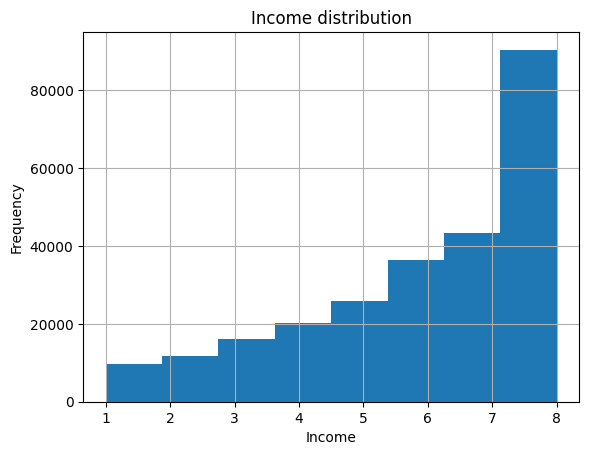

In [11]:
X['Income'].hist(bins=8)
plt.title('Income distribution')
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.show()

In [12]:
bins = [0, 3, 7, float('inf')]  # The range boundaries: 0-30k, 30k-70k, 70k+ matching 3 categories
labels = ['Low-income', 'Mid-income', 'High-income']  

X['Income_group'] = pd.cut(X['Income'], bins=bins, labels=labels, right=True)
X = pd.get_dummies(X, columns=['Income_group'], prefix='Income')
X_int = X.drop(columns=['BMI']).astype(int)
X = X.drop(columns=['Income'])

X.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income_Low-income,Income_Mid-income,Income_High-income
0,1.0,1.0,1.0,0.325581,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,True,False,False
1,0.0,0.0,0.0,0.151163,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,True,False,False
2,1.0,1.0,1.0,0.186047,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,False,False,True
3,1.0,0.0,1.0,0.174419,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,False,True,False
4,1.0,1.0,1.0,0.139535,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,False,True,False


In [13]:
# We do the same for the balnced X
X_balanced['Income_group'] = pd.cut(X_balanced['Income'], bins=bins, labels=labels, right=True)
X_balanced = pd.get_dummies(X_balanced, columns=['Income_group'], prefix='Income')
X_balanced = X_balanced.drop(columns=['Income'])

X_balanced.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income_Low-income,Income_Mid-income,Income_High-income
0,1.0,1.0,1.0,0.325581,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,True,False,False
1,0.0,0.0,0.0,0.151163,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,True,False,False
2,1.0,1.0,1.0,0.186047,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,False,False,True
3,1.0,0.0,1.0,0.174419,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,False,True,False
4,1.0,1.0,1.0,0.139535,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,False,True,False


## Education representation

1 - Never attended school or only kindergarten  
2 - Grades 1 through 8 (Elementary)  
3 - Grades 9 through 11 (Some high school)  
4 - Grade 12 or GED (High school graduate)  
5 - College 1 to 3 years (Some college or technical school)  
6 - College 4 years or more (College graduate)

This **Education** distribution shows an imbalance, with certain levels being much more represented than lower education levels. This imbalance could introduce bias in a predictive model, making it more tailored to patterns seen in highly educated individuals and potentially reducing accuracy for those with lower education levels. To address this, we could consider resampling techniques to balance the representation of each education level or adjust class weights in certain models. Additionally, since some classes are much less represented we can combine 1 - 3 into 1 category less than highschool or incomplete high school.

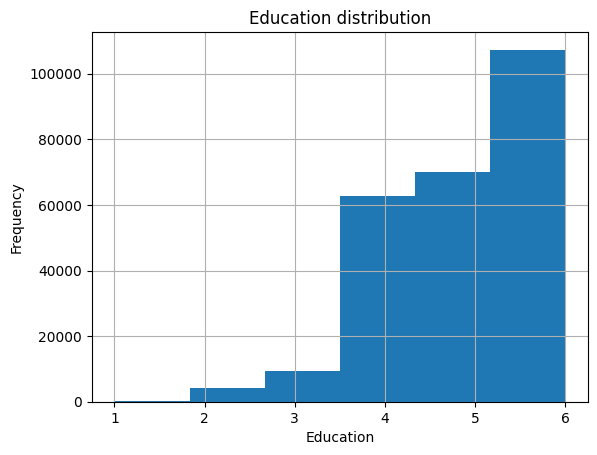

In [14]:
# Checking the skewness of the data and the distribution of education
df['Education'].hist(bins=6)
plt.title('Education distribution')
plt.xlabel('Education')
plt.ylabel('Frequency')
plt.show()

In [15]:
# Combine categories 1, 2, and 3 into one category for both X and X_balanced
X['Education'] = X['Education'].replace([1, 2, 3], 1)
X['Education'] = X['Education'].replace(4, 2)
X['Education'] = X['Education'].replace(5, 3)
X['Education'] = X['Education'].replace(6, 4)

# Convert all columns to integers except 'BMI'
for col in X_balanced.columns:
    if col != 'BMI':
        X_balanced[col] = X_balanced[col].astype(int)
        
X_balanced['Education'] = X_balanced['Education'].replace([1, 2, 3], 1)
X_balanced['Education'] = X_balanced['Education'].replace(4, 2)
X_balanced['Education'] = X_balanced['Education'].replace(5, 3)
X_balanced['Education'] = X_balanced['Education'].replace(6, 4)

In [16]:
# One-hot encode the 'Education' column for both X and X_balanced
education_dummies = pd.get_dummies(X['Education'], prefix='Education').astype(int)
X = pd.concat([X.drop(columns=['Education']), education_dummies], axis=1)

education_dummies_balanced = pd.get_dummies(X_balanced['Education'], prefix='Education').astype(int)
X_balanced = pd.concat([X_balanced.drop(columns=['Education']), education_dummies_balanced], axis=1)


In [17]:
# Convert all columns to integers except 'BMI' for both X and X_balanced
float_columns = ['BMI']

X[float_columns] = X[float_columns].astype(float)
X[X.columns.difference(float_columns)] = X[X.columns.difference(float_columns)].astype(int)

X_balanced[float_columns] = X_balanced[float_columns].astype(float)
X_balanced[X_balanced.columns.difference(float_columns)] = X_balanced[X_balanced.columns.difference(float_columns)].astype(int)

# Show all columns
pd.set_option('display.max_columns', None)

In [18]:
X.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Income_Low-income,Income_Mid-income,Income_High-income,Education_1.0,Education_2.0,Education_3.0,Education_4.0
0,1,1,1,0.325581,1,0,0,0,0,1,0,1,0,5,18,15,1,0,9,1,0,0,0,1,0,0
1,0,0,0,0.151163,1,0,0,1,0,0,0,0,1,3,0,0,0,0,7,1,0,0,0,0,0,1
2,1,1,1,0.186047,0,0,0,0,1,0,0,1,1,5,30,30,1,0,9,0,0,1,0,1,0,0
3,1,0,1,0.174419,0,0,0,1,1,1,0,1,0,2,0,0,0,0,11,0,1,0,1,0,0,0
4,1,1,1,0.139535,0,0,0,1,1,1,0,1,0,2,3,0,0,0,11,0,1,0,0,0,1,0


In [19]:
X_balanced.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Income_Low-income,Income_Mid-income,Income_High-income,Education_1,Education_2,Education_3,Education_4
0,1,1,1,0.325581,1,0,0,0,0,1,0,1,0,5,18,15,1,0,9,1,0,0,0,1,0,0
1,0,0,0,0.151163,1,0,0,1,0,0,0,0,1,3,0,0,0,0,7,1,0,0,0,0,0,1
2,1,1,1,0.186047,0,0,0,0,1,0,0,1,1,5,30,30,1,0,9,0,0,1,0,1,0,0
3,1,0,1,0.174419,0,0,0,1,1,1,0,1,0,2,0,0,0,0,11,0,1,0,1,0,0,0
4,1,1,1,0.139535,0,0,0,1,1,1,0,1,0,2,3,0,0,0,11,0,1,0,0,0,1,0


## Age representation

1 - Age 18 to 24  
2 - Age 25 to 29  
3 - Age 30 to 34  
4 - Age 35 to 39  
5 - Age 40 to 44  
6 - Age 45 to 49  
7 - Age 50 to 54  
8 - Age 55 to 59  
9 - Age 60 to 64  
10 - Age 65 to 69  
11 - Age 70 to 74  
12 - Age 75 to 79  
13 - Age 80 or older

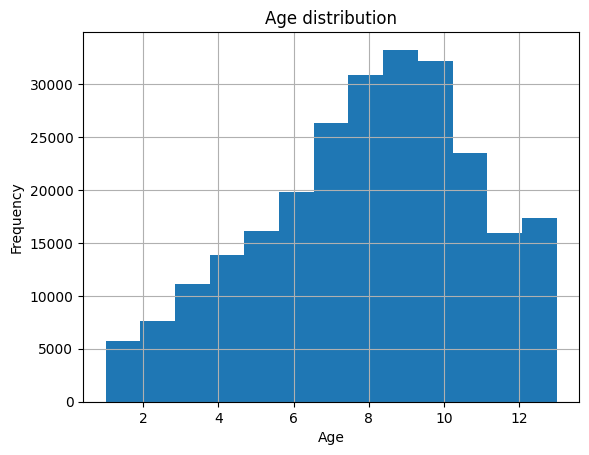

In [20]:
# check the distribution of ages across the dataset
X['Age'].hist(bins=13)
plt.title('Age distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [21]:
# Perform one-hot encoding for the 'Age' column
age_dummies = pd.get_dummies(X['Age'], prefix='Age').astype(int)
X = pd.concat([X.drop(columns=['Age']), age_dummies], axis=1)

X.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Income_Low-income,Income_Mid-income,Income_High-income,Education_1.0,Education_2.0,Education_3.0,Education_4.0,Age_1,Age_2,Age_3,Age_4,Age_5,Age_6,Age_7,Age_8,Age_9,Age_10,Age_11,Age_12,Age_13
0,1,1,1,0.325581,1,0,0,0,0,1,0,1,0,5,18,15,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0.151163,1,0,0,1,0,0,0,0,1,3,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,1,1,1,0.186047,0,0,0,0,1,0,0,1,1,5,30,30,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,1,0,1,0.174419,0,0,0,1,1,1,0,1,0,2,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,1,1,1,0.139535,0,0,0,1,1,1,0,1,0,2,3,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [22]:
# same for balanced dataset
age_dummies = pd.get_dummies(X_balanced['Age'], prefix='Age').astype(int)
X_balanced = pd.concat([X_balanced.drop(columns=['Age']), age_dummies], axis=1)

X_balanced.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Income_Low-income,Income_Mid-income,Income_High-income,Education_1,Education_2,Education_3,Education_4,Age_1,Age_2,Age_3,Age_4,Age_5,Age_6,Age_7,Age_8,Age_9,Age_10,Age_11,Age_12,Age_13
0,1,1,1,0.325581,1,0,0,0,0,1,0,1,0,5,18,15,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0.151163,1,0,0,1,0,0,0,0,1,3,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,1,1,1,0.186047,0,0,0,0,1,0,0,1,1,5,30,30,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,1,0,1,0.174419,0,0,0,1,1,1,0,1,0,2,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,1,1,1,0.139535,0,0,0,1,1,1,0,1,0,2,3,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0


## Skewed age
The distribution is left skewed so some categories are more represented than others. The age distribution in our dataset is left-skewed, meaning younger age groups are underrepresented compared to older ones. This skew could lead to the model being less accurate for younger age predictions, as fewer samples might make it harder to learn patterns specific to these age groups. To address this, we could apply resampling techniques to balance the distribution or use stratified sampling to ensure each age group is well-represented in both training and testing sets. However, given the dataset's large size (250,000 rows), even the smaller age groups likely have sufficient data to support learning, reducing the risk of model bias. Therefore, while the skew is present, the high volume of data should largely mitigate its potential impact, allowing the model to perform effectively across all age groups.

## Health Status
The **GenHlth** (General Health) score is represented by five categories indicating self-reported health status:

1 - Excellent  
2 - Very Good  
3 - Good  
4 - Fair  
5 - Poor  

Each category reflects a subjective assessment of overall health, with higher scores indicating poorer health. This ordinal scale allows us to capture a range of health perceptions from "Excellent" to "Poor," which may correlate with other health indicators in the dataset.

**MentHlth** represents the number of days in the past 30 days when a respondent’s mental health was "not good," including experiences of stress, depression, and emotional problems. This numeric variable ranges from 0 to 30, providing an indicator of mental health challenges over the past month.

**PhysHlth** represents the number of days in the past 30 days when a respondent’s physical health was "not good," including experiences of physical illness and injury. This numeric variable ranges from 0 to 30, providing an indicator of physical health challenges over the past month.


After scaling **MentHlth** and **PhysHlth** to a 0–1 range:

- **0** means no days of poor health.
- **1** represents the maximum (30 days) of poor health.
- Values between 0 and 1 indicate proportional days of poor health (e.g., 0.5 means 15 days). 

This makes these features comparable across different scales.

In [23]:
# Perform one-hot encoding for the 'GenHlth' column
genhlth_dummies = pd.get_dummies(X['GenHlth'], prefix='GenHlth').astype(int)
X = pd.concat([X.drop(columns=['GenHlth']), genhlth_dummies], axis=1)

X.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,MentHlth,PhysHlth,DiffWalk,Sex,Income_Low-income,Income_Mid-income,Income_High-income,Education_1.0,Education_2.0,Education_3.0,Education_4.0,Age_1,Age_2,Age_3,Age_4,Age_5,Age_6,Age_7,Age_8,Age_9,Age_10,Age_11,Age_12,Age_13,GenHlth_1,GenHlth_2,GenHlth_3,GenHlth_4,GenHlth_5
0,1,1,1,0.325581,1,0,0,0,0,1,0,1,0,18,15,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1,0,0,0,0.151163,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,1,1,1,0.186047,0,0,0,0,1,0,0,1,1,30,30,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
3,1,0,1,0.174419,0,0,0,1,1,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
4,1,1,1,0.139535,0,0,0,1,1,1,0,1,0,3,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0


In [24]:
# same for balanced dataset
genhlth_dummies = pd.get_dummies(X_balanced['GenHlth'], prefix='GenHlth').astype(int)
X_balanced = pd.concat([X_balanced.drop(columns=['GenHlth']), genhlth_dummies], axis=1)

X_balanced.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,MentHlth,PhysHlth,DiffWalk,Sex,Income_Low-income,Income_Mid-income,Income_High-income,Education_1,Education_2,Education_3,Education_4,Age_1,Age_2,Age_3,Age_4,Age_5,Age_6,Age_7,Age_8,Age_9,Age_10,Age_11,Age_12,Age_13,GenHlth_1,GenHlth_2,GenHlth_3,GenHlth_4,GenHlth_5
0,1,1,1,0.325581,1,0,0,0,0,1,0,1,0,18,15,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1,0,0,0,0.151163,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,1,1,1,0.186047,0,0,0,0,1,0,0,1,1,30,30,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
3,1,0,1,0.174419,0,0,0,1,1,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
4,1,1,1,0.139535,0,0,0,1,1,1,0,1,0,3,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0


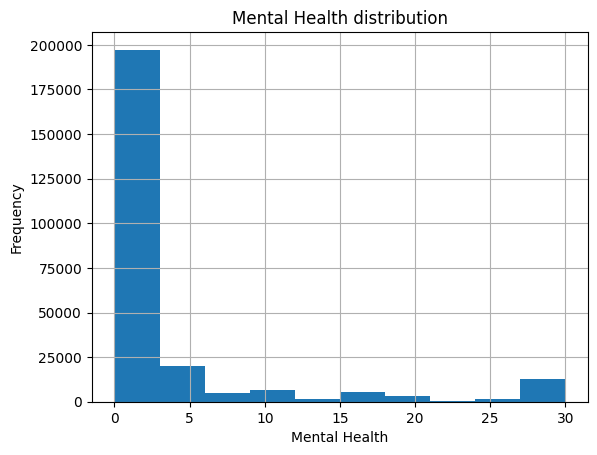

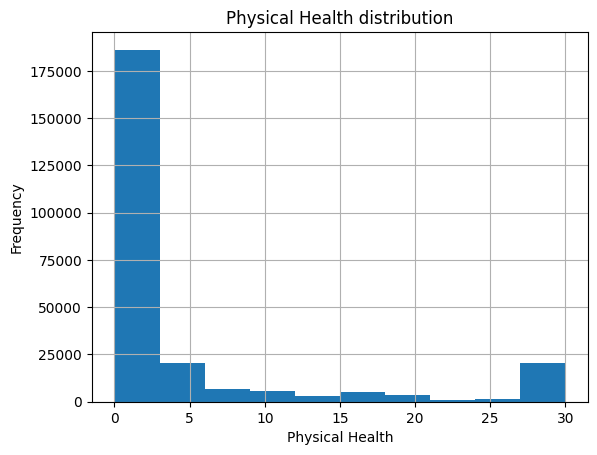

In [25]:
# Display the distribution of the 'MentHlth' feature
X['MentHlth'].hist(bins=10)
plt.title('Mental Health distribution')
plt.xlabel('Mental Health')
plt.ylabel('Frequency')
plt.show()

# Display the distribution of the 'PhysHlth' feature
X['PhysHlth'].hist(bins=10)
plt.title('Physical Health distribution')
plt.xlabel('Physical Health')
plt.ylabel('Frequency')
plt.show()

The **Mental Health** and **Physical Health** distributions are highly imbalanced, with the majority of respondents reporting very few or no days of poor health (values near 0 on the normalized scale). This imbalance could impact a model's ability to learn patterns for individuals with more frequent poor health days, as they are underrepresented in the data. 

To address this imbalance, we could group the days into broader categories to reduce imbalance while capturing meaningful variations.

In [26]:
def bin_health_days(days):
    if days == 0:
        return 0  # None
    elif 1 <= days <= 5:
        return 1  # Few
    elif 6 <= days <= 15:
        return 2  # Moderate
    else:
        return 3  # Many

# Apply the binning function to both MentHlth and PhysHlth
X['MentHlth_binned'] = X['MentHlth'].apply(bin_health_days)
X['PhysHlth_binned'] = X['PhysHlth'].apply(bin_health_days)

# Convert the binned columns to categorical data types
categories = [0, 1, 2, 3]
X['MentHlth_binned'] = pd.Categorical(X['MentHlth_binned'], categories=categories, ordered=True)
X['PhysHlth_binned'] = pd.Categorical(X['PhysHlth_binned'], categories=categories, ordered=True)

# drop the original columns
X = X.drop(columns=['MentHlth', 'PhysHlth'])

X.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,DiffWalk,Sex,Income_Low-income,Income_Mid-income,Income_High-income,Education_1.0,Education_2.0,Education_3.0,Education_4.0,Age_1,Age_2,Age_3,Age_4,Age_5,Age_6,Age_7,Age_8,Age_9,Age_10,Age_11,Age_12,Age_13,GenHlth_1,GenHlth_2,GenHlth_3,GenHlth_4,GenHlth_5,MentHlth_binned,PhysHlth_binned
0,1,1,1,0.325581,1,0,0,0,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,3,2
1,0,0,0,0.151163,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
2,1,1,1,0.186047,0,0,0,0,1,0,0,1,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,3,3
3,1,0,1,0.174419,0,0,0,1,1,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
4,1,1,1,0.139535,0,0,0,1,1,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0


In [27]:
# same for balanced dataset
X_balanced['MentHlth_binned'] = X_balanced['MentHlth'].apply(bin_health_days)
X_balanced['PhysHlth_binned'] = X_balanced['PhysHlth'].apply(bin_health_days)
X_balanced['MentHlth_binned'] = pd.Categorical(X_balanced['MentHlth_binned'], categories=categories, ordered=True)
X_balanced['PhysHlth_binned'] = pd.Categorical(X_balanced['PhysHlth_binned'], categories=categories, ordered=True)

X_balanced = X_balanced.drop(columns=['MentHlth', 'PhysHlth'])

X_balanced.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,DiffWalk,Sex,Income_Low-income,Income_Mid-income,Income_High-income,Education_1,Education_2,Education_3,Education_4,Age_1,Age_2,Age_3,Age_4,Age_5,Age_6,Age_7,Age_8,Age_9,Age_10,Age_11,Age_12,Age_13,GenHlth_1,GenHlth_2,GenHlth_3,GenHlth_4,GenHlth_5,MentHlth_binned,PhysHlth_binned
0,1,1,1,0.325581,1,0,0,0,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,3,2
1,0,0,0,0.151163,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
2,1,1,1,0.186047,0,0,0,0,1,0,0,1,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,3,3
3,1,0,1,0.174419,0,0,0,1,1,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
4,1,1,1,0.139535,0,0,0,1,1,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0


In [28]:
# Perform one-hot encoding for the binned columns
menthlth_dummies = pd.get_dummies(X['MentHlth_binned'], prefix='MentHlth').astype(int)
phys_hlth_dummies = pd.get_dummies(X['PhysHlth_binned'], prefix='PhysHlth').astype(int)

# Drop the original binned columns and concatenate the dummies
X = pd.concat([X.drop(columns=['MentHlth_binned', 'PhysHlth_binned']), menthlth_dummies, phys_hlth_dummies], axis=1)

# Display the resulting DataFrame
X.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,DiffWalk,Sex,Income_Low-income,Income_Mid-income,Income_High-income,Education_1.0,Education_2.0,Education_3.0,Education_4.0,Age_1,Age_2,Age_3,Age_4,Age_5,Age_6,Age_7,Age_8,Age_9,Age_10,Age_11,Age_12,Age_13,GenHlth_1,GenHlth_2,GenHlth_3,GenHlth_4,GenHlth_5,MentHlth_0,MentHlth_1,MentHlth_2,MentHlth_3,PhysHlth_0,PhysHlth_1,PhysHlth_2,PhysHlth_3
0,1,1,1,0.325581,1,0,0,0,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0
1,0,0,0,0.151163,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0
2,1,1,1,0.186047,0,0,0,0,1,0,0,1,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1
3,1,0,1,0.174419,0,0,0,1,1,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0
4,1,1,1,0.139535,0,0,0,1,1,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0


In [29]:
# same for balanced dataset
menthlth_dummies = pd.get_dummies(X_balanced['MentHlth_binned'], prefix='MentHlth').astype(int)
phys_hlth_dummies = pd.get_dummies(X_balanced['PhysHlth_binned'], prefix='PhysHlth').astype(int)

X_balanced = pd.concat([X_balanced.drop(columns=['MentHlth_binned', 'PhysHlth_binned']), menthlth_dummies, phys_hlth_dummies], axis=1)

X_balanced.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,DiffWalk,Sex,Income_Low-income,Income_Mid-income,Income_High-income,Education_1,Education_2,Education_3,Education_4,Age_1,Age_2,Age_3,Age_4,Age_5,Age_6,Age_7,Age_8,Age_9,Age_10,Age_11,Age_12,Age_13,GenHlth_1,GenHlth_2,GenHlth_3,GenHlth_4,GenHlth_5,MentHlth_0,MentHlth_1,MentHlth_2,MentHlth_3,PhysHlth_0,PhysHlth_1,PhysHlth_2,PhysHlth_3
0,1,1,1,0.325581,1,0,0,0,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0
1,0,0,0,0.151163,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0
2,1,1,1,0.186047,0,0,0,0,1,0,0,1,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1
3,1,0,1,0.174419,0,0,0,1,1,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0
4,1,1,1,0.139535,0,0,0,1,1,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0


In [30]:
print("Shape of X:\n",X_balanced.shape)
print("Shape of the balanced X:\n",X.shape)

Shape of X:
 (641109, 48)
Shape of the balanced X:
 (253680, 48)


# Final look at the data before modeling #


In [31]:
# data columns
print("Columns:\n",X_balanced.columns)

Columns:
 Index(['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex',
       'Income_Low-income', 'Income_Mid-income', 'Income_High-income',
       'Education_1', 'Education_2', 'Education_3', 'Education_4', 'Age_1',
       'Age_2', 'Age_3', 'Age_4', 'Age_5', 'Age_6', 'Age_7', 'Age_8', 'Age_9',
       'Age_10', 'Age_11', 'Age_12', 'Age_13', 'GenHlth_1', 'GenHlth_2',
       'GenHlth_3', 'GenHlth_4', 'GenHlth_5', 'MentHlth_0', 'MentHlth_1',
       'MentHlth_2', 'MentHlth_3', 'PhysHlth_0', 'PhysHlth_1', 'PhysHlth_2',
       'PhysHlth_3'],
      dtype='object')


In [32]:
df = pd.concat([X, y], axis=1)
df_balanced = pd.concat([X_balanced, y_balanced], axis=1)

In [33]:
# Display the merged DataFrames
df.head()
df_balanced.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,DiffWalk,Sex,Income_Low-income,Income_Mid-income,Income_High-income,Education_1,Education_2,Education_3,Education_4,Age_1,Age_2,Age_3,Age_4,Age_5,Age_6,Age_7,Age_8,Age_9,Age_10,Age_11,Age_12,Age_13,GenHlth_1,GenHlth_2,GenHlth_3,GenHlth_4,GenHlth_5,MentHlth_0,MentHlth_1,MentHlth_2,MentHlth_3,PhysHlth_0,PhysHlth_1,PhysHlth_2,PhysHlth_3,Diabetes_012
0,1,1,1,0.325581,1,0,0,0,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0.0
1,0,0,0,0.151163,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0.0
2,1,1,1,0.186047,0,0,0,0,1,0,0,1,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0.0
3,1,0,1,0.174419,0,0,0,1,1,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0.0
4,1,1,1,0.139535,0,0,0,1,1,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0.0


## Milestone 3 ## 

### Data Description

This project leverages data from the **Behavioral Risk Factor Surveillance System (BRFSS)**, a large-scale health-related telephone survey conducted annually by the CDC. The BRFSS collects responses from over 400,000 Americans on topics including health-related behaviors, chronic health conditions, and the use of preventive services. Our dataset, derived from this survey, contains responses from around 250,000 individuals and focuses on 22 selected features relevant to diabetes prediction. The BRFSS has been conducted every year since 1984, providing a reliable and comprehensive source for health-related research.

The target variable in this dataset indicates diabetes onset, with three categories: 
- **0** for no diabetes (or gestational diabetes only), 
- **1** for prediabetes, and 
- **2** for diabetes (either Type 1 or Type 2, without differentiation). 
Our objective is to predict these outcomes based on patient responses to survey questions, identifying potential risk factors for diabetes onset.
The solution to predicting this will be by using multiclass classification.

#### Data Collection Process
The data was collected via telephone surveys, with questions covering various aspects of health, lifestyle, and demographics. For this project, only 22 columns were selected out of the full survey, focusing on attributes most likely to influence or indicate diabetes risk.

#### Data Preprocessing
Data preprocessing included several steps to prepare the dataset for analysis:
- **Class Imbalance Adjustment**: We used techniques like SMOTE to address class imbalance, especially since categories 1 (prediabetes) and 2 (diabetes) were underrepresented compared to category 0.
- **Feature Engineering**: Continuous features were transformed into categories to enhance interpretability. We combined and grouped certain categories (e.g., income, education) to simplify analysis and reduce skewness. We use one hot encoding.
- **Scaling and Normalization**: Features like **BMI** were scaled down (indicating days of poor mental and physical health) were normalized on a 0-1 scale for consistency across variables.


## Data Summary
The dataset underwent extensive cleaning, transformation, and validation to ensure readiness for analysis. We started by examining and addressing class imbalances, particularly in target variables, using techniques like SMOTE to balance underrepresented groups. Continuous features, such as **BMI**, were transformed into categories to improve interpretability, while ordinal and categorical variables, like **Income** and **Education**, were one-hot encoded or grouped into broader categories. We standardized numerical features where necessary to handle differences in scale and ensure consistency. Key health indicators, including **GenHlth**, **MentHlth**, and **PhysHlth**, represent self-reported general, mental, and physical health, respectively, with values indicating frequency or severity. The final dataset includes a mix of demographic, lifestyle, and health-related features, fully refined and ready for exploratory analysis. Visualizations such as histograms and correlation plots provide insights into feature distributions and relationships, supporting further analysis and modeling.

## EDA ##


The distribution is now evenly split among the categories of No Diabetes, Prediabetes, and Diabetes. This balance is achieved through the use of SMOTE, which addresses the original imbalance by increasing the representation of diabetes cases relative to non-diabetes cases. Now we can visualize some of the other categories, features and their relation to the target variable.

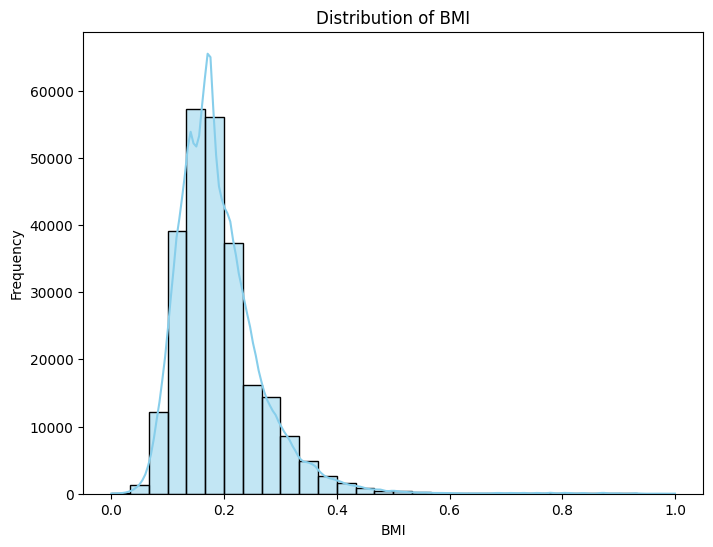

In [34]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='BMI', bins=30, kde=True, color='skyblue') 
plt.title('Distribution of BMI')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.show()

We see some data imbalance as there is a very low number of peoeple that fall in the underweight group which could lead to missrepresentation of this group in the final models.

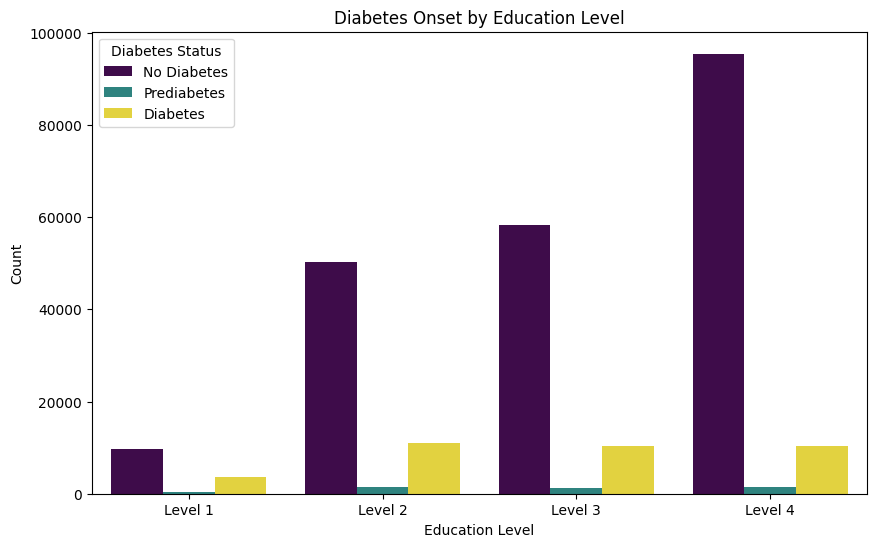

In [35]:
education_columns = ['Education_1.0', 'Education_2.0', 'Education_3.0', 'Education_4.0']
df_melted = df.melt(id_vars=['Diabetes_012'], value_vars=education_columns, 
                    var_name='Education', value_name='Count')
df_melted = df_melted[df_melted['Count'] > 0]


education_labels = {
    'Education_1.0': 'Level 1',
    'Education_2.0': 'Level 2',
    'Education_3.0': 'Level 3',
    'Education_4.0': 'Level 4'
}
df_melted['Education'] = df_melted['Education'].map(education_labels)

# Plot the countplot
plt.figure(figsize=(10, 6))
sns.countplot(data=df_melted, x='Education', hue='Diabetes_012', palette='viridis')
plt.title('Diabetes Onset by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.legend(title='Diabetes Status', labels=['No Diabetes', 'Prediabetes', 'Diabetes'])
plt.show()


The graph above shows that people with higher education levels are less likely to have diabetes. This could be because higher education often brings more knowledge about healthy habits, like eating well, staying active, and managing stress—habits that help prevent diabetes. Additionally, people with more education may have better access to healthcare and healthier food options, which can also lower their risk of developing diabetes.

Seeing this, we recognize that education level is an important feature to include in our model for explaining diabetes risk. By incorporating education as a predictor, we can improve the model’s ability to capture underlying social and lifestyle factors that contribute to diabetes outcomes.

However, an issue with education as a predictor is that possibility of a cofounding variable such as family background. A survey participant who came from a high-income family is likely to be able to efford higher education and healtcare so by only considering education as a predictor, we are likely overestimating the effect it has on our response variable.

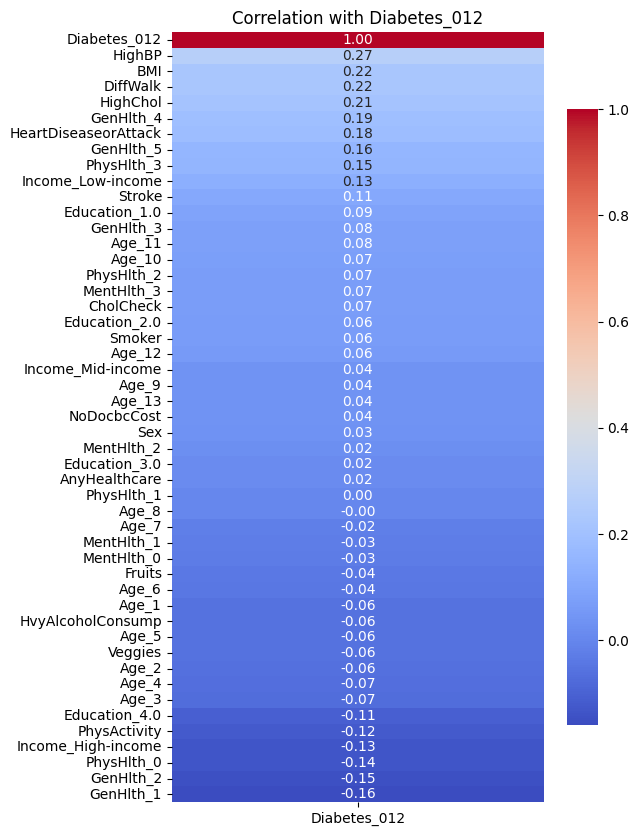

In [36]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Extract only the correlations with 'Diabetes_012'
diabetes_corr = corr_matrix[['Diabetes_012']].sort_values(by='Diabetes_012', ascending=False)

# Plot the correlation heatmap for 'Diabetes_012' only
plt.figure(figsize=(6, 10))
sns.heatmap(diabetes_corr, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={"shrink": 0.8})
plt.title('Correlation with Diabetes_012')
plt.show()



### Best Predictors for Diabetes (`Diabetes_012`)

**HighBP (0.27):**  
High blood pressure stands out as the strongest predictor of diabetes. It’s not surprising since issues like poor diet, lack of exercise, and weight gain often contribute to both conditions. This makes it an essential factor to keep an eye on when assessing diabetes risk.

**BMI (0.22):**  
Body Mass Index is another big one. Excess weight can lead to insulin resistance, making diabetes much more likely. Managing weight through diet and exercise is key to lowering this risk.

**DiffWalk (0.22):**  
Difficulty walking is strongly connected to diabetes, likely because it reflects physical inactivity or other health challenges. It’s a sign that mobility and lifestyle habits are critical in understanding who’s at risk.

**HighChol (0.21):**  
High cholesterol is also a factor, tying into unhealthy diets and sedentary lifestyles. While it’s not the strongest predictor, it’s worth considering since it often coexists with other risk factors.

**GenHealth_4 (0.19):**  
People who rate their general health as very poor are at significantly higher risk. This makes sense—poor overall health often reflects a combination of chronic issues, including diabetes.

**Heart Disease or Attack (0.18):**  
Having heart disease or a history of heart attacks is another strong indicator. The link between cardiovascular problems and diabetes is well-documented, as both share many of the same underlying causes.

**GenHealth (0.15):**  
Even slightly lower ratings of general health can indicate a higher risk. It’s a reminder that how someone feels about their overall health is often a good indicator of underlying issues.

**PhysHlth_3 (0.15):**  
Severe physical health problems are another important factor. Chronic illness often limits physical activity, which can spiral into higher diabetes risk.

**Income_LowIncome (-0.13):**  
Lower income is mildly associated with higher diabetes risk. This might be due to limited access to healthy food, regular medical care, or resources for maintaining a healthy lifestyle. It’s a reminder that socioeconomic factors matter.

### What It All Means:  
The biggest takeaways here are that physical health, weight, and mobility are key to predicting diabetes risk. HighBP, BMI, and DiffWalk stand out as the strongest predictors, but factors like cholesterol, heart disease, and general health also play important roles. Even income ties in, showing how lifestyle and access to resources can shape health outcomes. It’s a mix of physical, lifestyle, and socioeconomic influences that paint the full picture of diabetes risk.

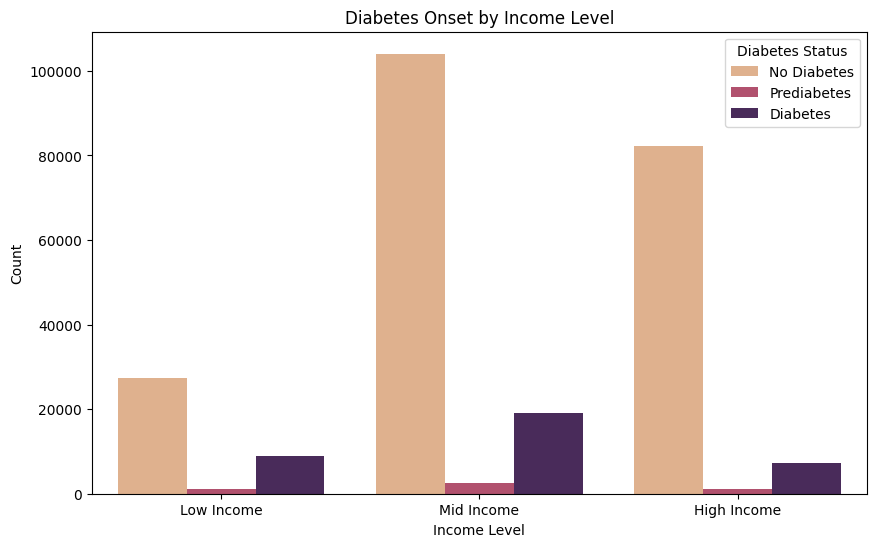

In [37]:
income_columns = ['Income_Low-income', 'Income_Mid-income', 'Income_High-income']
df_melted = df[income_columns + ['Diabetes_012']].melt(
    id_vars='Diabetes_012', 
    var_name='Income', 
    value_name='Count'
)

df_melted = df_melted[df_melted['Count'] > 0]
df_melted['Income'] = df_melted['Income'].replace({
    'Income_Low-income': 'Low Income',
    'Income_Mid-income': 'Mid Income',
    'Income_High-income': 'High Income'
})

plt.figure(figsize=(10, 6))
sns.countplot(data=df_melted, x='Income', hue='Diabetes_012', palette='flare')
plt.title('Diabetes Onset by Income Level')
plt.xlabel('Income Level')
plt.ylabel('Count')
plt.legend(title='Diabetes Status', labels=['No Diabetes', 'Prediabetes', 'Diabetes'])
plt.show()


As shown in the graph above, income is strongly correlated with diabetes risk. Higher-income individuals tend to have better access to a healthy lifestyle, including options like organic food, regular healthcare, and preventive resources. This access supports healthier habits, which may reduce their likelihood of developing diabetes.

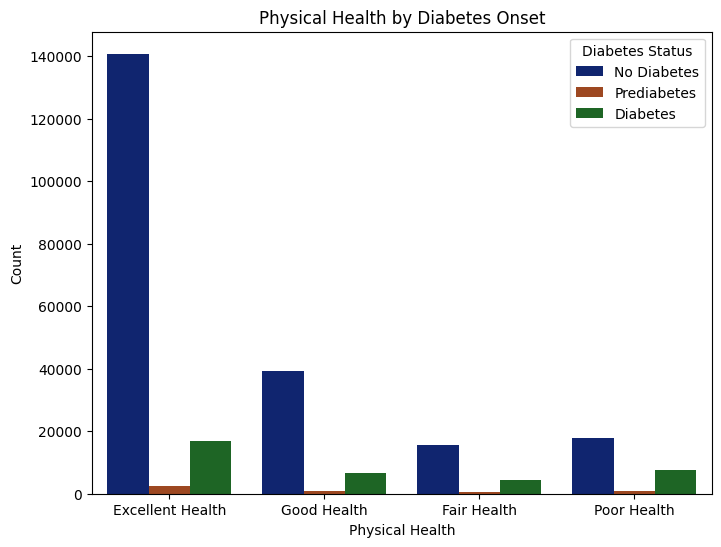

In [38]:
phys_health_columns = ['PhysHlth_0', 'PhysHlth_1', 'PhysHlth_2', 'PhysHlth_3']
df_melted = df[phys_health_columns + ['Diabetes_012']].melt(
    id_vars='Diabetes_012', 
    var_name='PhysHealth', 
    value_name='Count'
)

df_melted = df_melted[df_melted['Count'] > 0]
df_melted['PhysHealth'] = df_melted['PhysHealth'].replace({
    'PhysHlth_0': 'Excellent Health',
    'PhysHlth_1': 'Good Health',
    'PhysHlth_2': 'Fair Health',
    'PhysHlth_3': 'Poor Health'
})

plt.figure(figsize=(8, 6))
sns.countplot(data=df_melted, x='PhysHealth', hue='Diabetes_012', palette='dark')
plt.title('Physical Health by Diabetes Onset')
plt.xlabel('Physical Health')
plt.ylabel('Count')
plt.legend(title='Diabetes Status', labels=['No Diabetes', 'Prediabetes', 'Diabetes'])
plt.show()

People who are more physically active are more likely to maintain good health and have a lower risk of developing diabetes. Regular physical activity helps manage weight, improves insulin sensitivity, and supports overall metabolic health, all of which are key factors in reducing diabetes risk.

As we go throuh the EDA, one might notice an issue of collinearity within the dataset, where certain features are highly correlated with each other. We’ll delve into this potential problem in more detail below in the ending of the notebook.

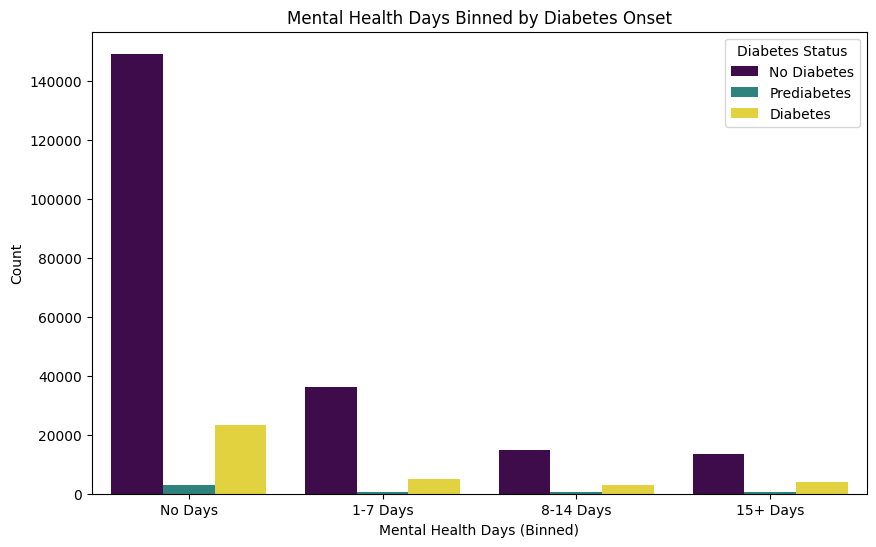

In [39]:
ment_health_columns = ['MentHlth_0', 'MentHlth_1', 'MentHlth_2', 'MentHlth_3']
df_melted = df[ment_health_columns + ['Diabetes_012']].melt(
    id_vars='Diabetes_012', 
    var_name='MentHealth', 
    value_name='Count'
)

df_melted = df_melted[df_melted['Count'] > 0]
df_melted['MentHealth'] = df_melted['MentHealth'].replace({
    'MentHlth_0': 'No Days',
    'MentHlth_1': '1-7 Days',
    'MentHlth_2': '8-14 Days',
    'MentHlth_3': '15+ Days'
})

plt.figure(figsize=(10, 6))
sns.countplot(data=df_melted, x='MentHealth', hue='Diabetes_012', palette='viridis')
plt.title('Mental Health Days Binned by Diabetes Onset')
plt.xlabel('Mental Health Days (Binned)')
plt.ylabel('Count')
plt.legend(title='Diabetes Status', labels=['No Diabetes', 'Prediabetes', 'Diabetes'])
plt.show()

The mental health days count does not show a clear distinction across diabetes classes among the categories "many," "none," and "few." This lack of separation suggests that mental health days may not be a strong predictor of diabetes on its own. However, this is an area that should be further explored to determine if there might be subtler patterns or interactions with other features that could contribute to diabetes prediction.

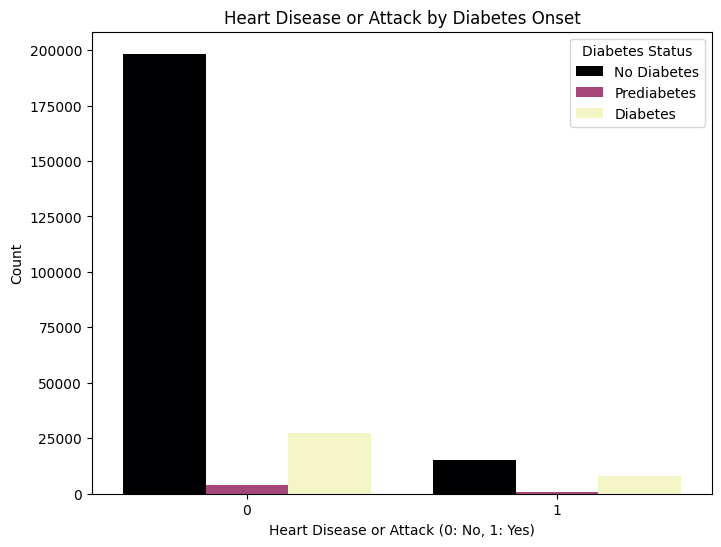

In [40]:
# Heart Disease or Attack vs Diabetes Onset
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='HeartDiseaseorAttack', hue='Diabetes_012', palette='magma')
plt.title('Heart Disease or Attack by Diabetes Onset')
plt.xlabel('Heart Disease or Attack (0: No, 1: Yes)')
plt.ylabel('Count')
plt.legend(title='Diabetes Status', labels=['No Diabetes', 'Prediabetes', 'Diabetes'])
plt.show()

As we saw in the heatmap, there seems to be a correlation between prediabetes and a history of heart attack. This relationship could be explained by the fact that individuals who have experienced a heart attack may be more motivated to improve their diet and lifestyle to prevent further health issues, potentially delaying or managing diabetes progression.

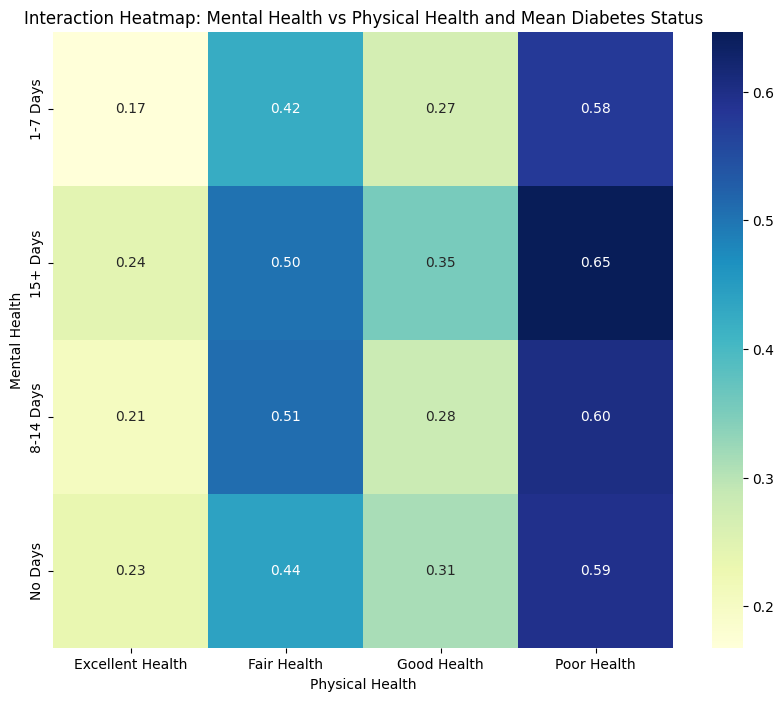

In [41]:

menthlth_groups = ['MentHlth_0', 'MentHlth_1', 'MentHlth_2', 'MentHlth_3']
df['MentHlth'] = df[menthlth_groups].idxmax(axis=1)

phys_hlth_groups = ['PhysHlth_0', 'PhysHlth_1', 'PhysHlth_2', 'PhysHlth_3']
df['PhysHlth'] = df[phys_hlth_groups].idxmax(axis=1)

df['MentHlth'] = df['MentHlth'].replace({
    'MentHlth_0': 'No Days',
    'MentHlth_1': '1-7 Days',
    'MentHlth_2': '8-14 Days',
    'MentHlth_3': '15+ Days'
})

df['PhysHlth'] = df['PhysHlth'].replace({
    'PhysHlth_0': 'Excellent Health',
    'PhysHlth_1': 'Good Health',
    'PhysHlth_2': 'Fair Health',
    'PhysHlth_3': 'Poor Health'
})

interaction_data_health = df.groupby(['MentHlth', 'PhysHlth'])['Diabetes_012'].mean().unstack().fillna(0)
plt.figure(figsize=(10, 8))
sns.heatmap(interaction_data_health, annot=True, fmt=".2f", cmap='YlGnBu', cbar=True)
plt.title('Interaction Heatmap: Mental Health vs Physical Health and Mean Diabetes Status')
plt.xlabel('Physical Health')
plt.ylabel('Mental Health')
plt.show()


This heatmap visualizes the interaction between general health index, physical health, and mean diabetes status. We observe that as the general health index worsens (from excellent to poor), the average diabetes status increases across all categories of physical health. This trend suggests that poorer self-reported general health is strongly associated with a higher likelihood of diabetes.

Interestingly, the correlation between worsening general health and mean diabetes status intensifies further when individuals report more days of poor mental health. This indicates that poor mental health may amplify the relationship between declining general health and the likelihood of diabetes. 

# Base modeling #
Creating a base model with the majority class now is impossible specificallly for the diabetes_012 column since we equalized them because there is a class imbalance we don't want to affect our predictions. We want to strictly use predictors to learn our diabetes status. We choose knn or logistic regression as some baseline model.


In [42]:
# Split the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,DiffWalk,Sex,Income_Low-income,Income_Mid-income,Income_High-income,Education_1.0,Education_2.0,Education_3.0,Education_4.0,Age_1,Age_2,Age_3,Age_4,Age_5,Age_6,Age_7,Age_8,Age_9,Age_10,Age_11,Age_12,Age_13,GenHlth_1,GenHlth_2,GenHlth_3,GenHlth_4,GenHlth_5,MentHlth_0,MentHlth_1,MentHlth_2,MentHlth_3,PhysHlth_0,PhysHlth_1,PhysHlth_2,PhysHlth_3
185494,1,0,1,0.151163,0,0,0,1,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0
217030,0,0,1,0.290698,1,0,0,1,1,1,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0
641,1,1,1,0.267442,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0
217863,0,0,1,0.174419,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0
53677,0,0,1,0.186047,1,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0


In [43]:
# train test split for balanced dataset
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)
X_train_balanced.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,DiffWalk,Sex,Income_Low-income,Income_Mid-income,Income_High-income,Education_1,Education_2,Education_3,Education_4,Age_1,Age_2,Age_3,Age_4,Age_5,Age_6,Age_7,Age_8,Age_9,Age_10,Age_11,Age_12,Age_13,GenHlth_1,GenHlth_2,GenHlth_3,GenHlth_4,GenHlth_5,MentHlth_0,MentHlth_1,MentHlth_2,MentHlth_3,PhysHlth_0,PhysHlth_1,PhysHlth_2,PhysHlth_3
320812,0,0,1,0.174419,0,0,0,1,1,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0
181926,1,1,1,0.197674,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
524102,0,1,1,0.174775,1,0,0,1,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0
573967,1,1,1,0.202434,1,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1
286902,1,1,1,0.151163,0,0,1,1,1,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0


## I want to try to see other redictors


Best k: 3
Best Validation Accuracy: 0.8363385378484192
Train Accuracy for Best k: 0.981838104689727


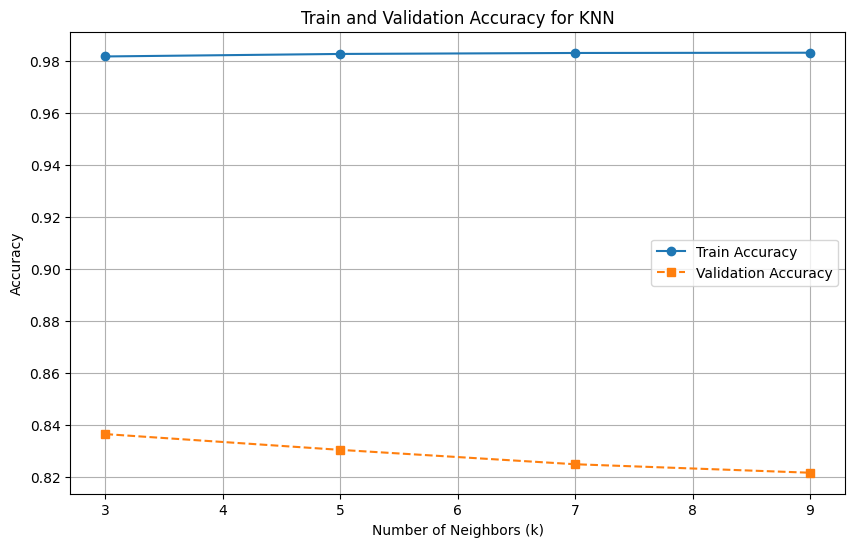

In [44]:
# Define the range of k values
ks = [3, 5, 7, 9]
train_scores = []
val_scores = []

# Loop through each k value
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance', metric='euclidean')
    knn.fit(X_train_balanced, y_train_balanced)
    
    y_train_pred = knn.predict(X_train_balanced)
    train_scores.append(accuracy_score(y_train_balanced, y_train_pred))
    
    y_val_pred = knn.predict(X_test_balanced)
    val_scores.append(accuracy_score(y_test_balanced, y_val_pred))

best_k = ks[val_scores.index(max(val_scores))]

print(f"Best k: {best_k}")
print(f"Best Validation Accuracy: {max(val_scores)}")
print(f"Train Accuracy for Best k: {train_scores[val_scores.index(max(val_scores))]}")

plt.figure(figsize=(10, 6))
plt.plot(ks, train_scores, marker='o', label='Train Accuracy', linestyle='-')
plt.plot(ks, val_scores, marker='s', label='Validation Accuracy', linestyle='--')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy for KNN')
plt.legend()
plt.grid(True)
plt.show()

The model achieves an overall accuracy of 83%, meaning it correctly predicts diabetes status most of the time. We used a balanced dataset because classes particularly imbalanced, and in this case even the base modeli predicting the majority class would predict very well. We wanted to avoid missclassification of the imbalanced classes, and that's why we used SMOTE here.

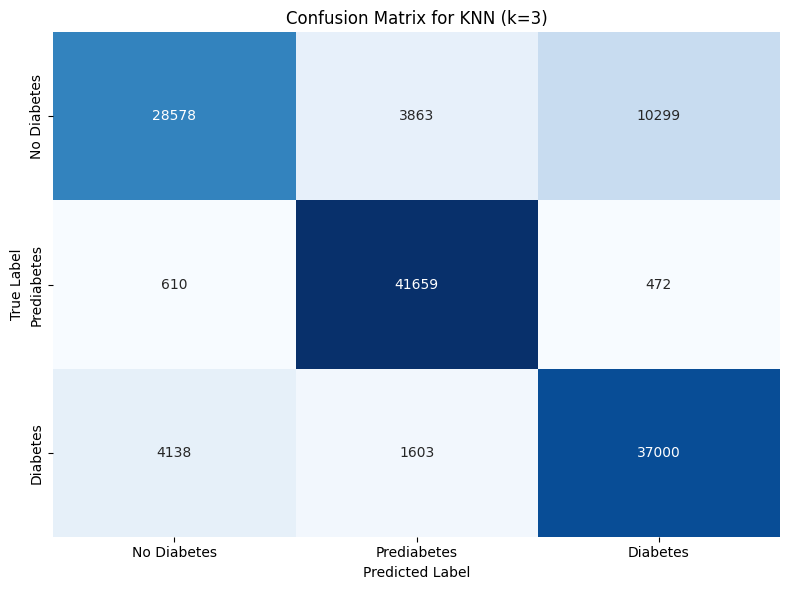

In [45]:

knn_model = KNeighborsClassifier(n_neighbors=best_k, weights='distance', metric='euclidean')
knn_model.fit(X_train_balanced, y_train_balanced)
y_pred_knn = knn_model.predict(X_test_balanced)


conf_matrix_knn = confusion_matrix(y_test_balanced, y_pred_knn)
labels = ['No Diabetes', 'Prediabetes', 'Diabetes']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_knn, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels, cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix for KNN (k={best_k})')
plt.tight_layout()
plt.show()

The graph above displays the number of true positives, true negatives, false positives, and false negatives. A concern is the high number of falsely predicted diabetes patients (false positives), which indicates a less-than-ideal performance in distinguishing diabetes cases. This could be attributed to the model's sensitivity toward the diabetes boundary, as it appears to prioritize better performance in predicting prediabetes and diabetes classes. This trade-off might explain the model's inclination to err on the side of false positives, favoring the identification of potential diabetes cases at the expense of precision. Additionally, we see that the model does poorly with misslassifying patients not having diabetes, and this might be due to the quality of the data, since it is a survey and people self-assess their health outcomes. 

# Logistic regression #

In [46]:
# Define the pipeline 
pipeline = Pipeline(steps=[
    ('classifier', LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42))
])

param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
}

grid_search_logistic = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1,
    verbose=1
)

grid_search_logistic.fit(X_train, y_train)

best_logistic = grid_search_logistic.best_estimator_
y_pred_logistic = best_logistic.predict(X_test)

# Print results
print("Best Logistic Regression Parameters:", grid_search_logistic.best_params_)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logistic))
print(classification_report(y_test, y_pred_logistic))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/andrejbasica/anaconda3/envs/new_env_name/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/andrejbasica/anaconda3/envs/new_env_name/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/andrejbasica/anaconda3/envs/new_env_name/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/andrejbasica/anaconda3/envs

Best Logistic Regression Parameters: {'classifier__C': 100}
Logistic Regression Accuracy: 0.8481748659728792
              precision    recall  f1-score   support

         0.0       0.86      0.98      0.92     42741
         1.0       0.00      0.00      0.00       926
         2.0       0.55      0.18      0.27      7069

    accuracy                           0.85     50736
   macro avg       0.47      0.39      0.39     50736
weighted avg       0.80      0.85      0.81     50736



/Users/andrejbasica/anaconda3/envs/new_env_name/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/andrejbasica/anaconda3/envs/new_env_name/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/andrejbasica/anaconda3/envs/new_env_name/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

The logistic regression model demonstrates a high overall accuracy of 85%, which at first glance seems impressive. However, a closer look reveals significant issues in the model's performance, particularly for minority classes. The precision, recall, and f1-score for class 1.0 (diabetes) are all 0.00, indicating that the model fails to correctly identify patients in this category, instead frequently misclassifying them as 0.0 (no diabetes).

The primary reason for this poor performance is likely the class imbalance in the dataset, with a disproportionately large number of samples in the 0.0 class. Logistic regression tends to favor the majority class during training, which results in high precision and recall for 0.0, as seen with a recall of 0.98 for this class. This skew towards the majority class also explains the high overall accuracy since the model predicts the majority class (0.0) well.

However, the macro average accuracy is significantly lower, at just 39%, reflecting the model's inability to generalize across all classes. The weighted average accuracy is somewhat higher (81%) but still fails to compensate for the model's poor performance in minority classes.

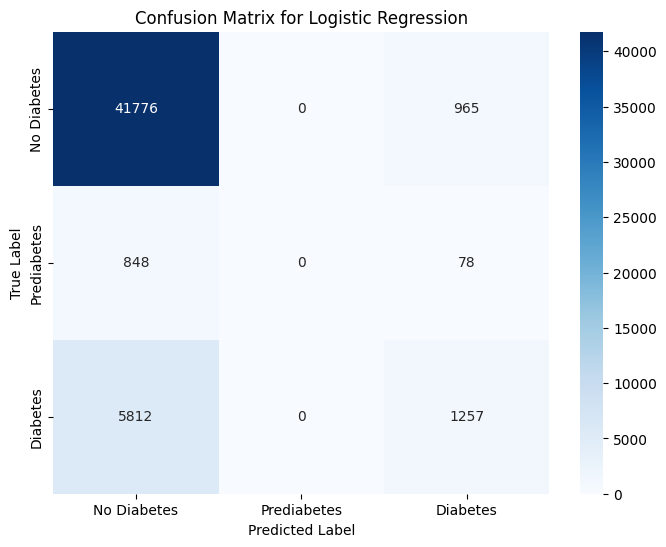

In [47]:
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_logistic)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['No Diabetes', 'Prediabetes', 'Diabetes'], 
            yticklabels=['No Diabetes', 'Prediabetes', 'Diabetes'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

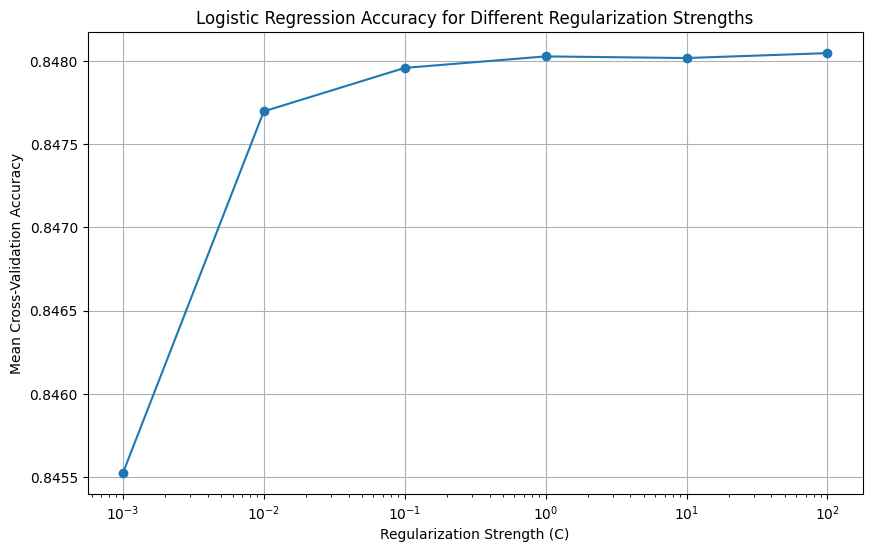

In [48]:

# Visualize the relationship between regularization strength and accuracy
cv_results = grid_search_logistic.cv_results_
accuracy_scores = cv_results['mean_test_score']
C_values = cv_results['param_classifier__C'].data

plt.figure(figsize=(10, 6))
plt.plot(C_values, accuracy_scores, marker='o', linestyle='-')
plt.xscale('log')
plt.xlabel('Regularization Strength (C)')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.title('Logistic Regression Accuracy for Different Regularization Strengths')
plt.grid(True)
plt.show()

 # Decision tree #

In [49]:
param_grid = {
    'max_depth': [None, 5, 10, 15, 20, 25, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

tree = DecisionTreeClassifier(random_state=42)

grid_search_tree = GridSearchCV(
    estimator=tree,
    param_grid=param_grid,
    cv=5, 
    scoring='accuracy',
    return_train_score=True,  
    n_jobs=-1,
    verbose=1
)

grid_search_tree.fit(X_train, y_train)

best_tree = grid_search_tree.best_estimator_
y_pred_tree = best_tree.predict(X_test)


print("Best Decision Tree Parameters:", grid_search_tree.best_params_)
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree))


cv_results = grid_search_tree.cv_results_
mean_train_scores = cv_results['mean_train_score']
mean_val_scores = cv_results['mean_test_score']
param_max_depth = [param['max_depth'] for param in cv_results['params']]

depths = sorted([depth for depth in set(param_max_depth) if depth is not None])


Fitting 5 folds for each of 63 candidates, totalling 315 fits
Best Decision Tree Parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Decision Tree Accuracy: 0.8459082308420057
              precision    recall  f1-score   support

         0.0       0.86      0.98      0.92     42741
         1.0       0.00      0.00      0.00       926
         2.0       0.53      0.13      0.21      7069

    accuracy                           0.85     50736
   macro avg       0.46      0.37      0.38     50736
weighted avg       0.80      0.85      0.80     50736



/Users/andrejbasica/anaconda3/envs/new_env_name/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/andrejbasica/anaconda3/envs/new_env_name/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/andrejbasica/anaconda3/envs/new_env_name/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

The decision tree model, with a best accuracy of 84.6%, performs well for the majority class (no diabetes) with high recall (0.98) and f1-score (0.92), but completely fails for class diabetes with all metrics at 0. The macro averages (recall: 0.37, f1-score: 0.38) highlight this imbalance, as the model prioritizes majority class predictions, ignoring minority classes. To improve diabetes prediction, techniques like class weighting or resampling are necessary to address the dataset's imbalance.

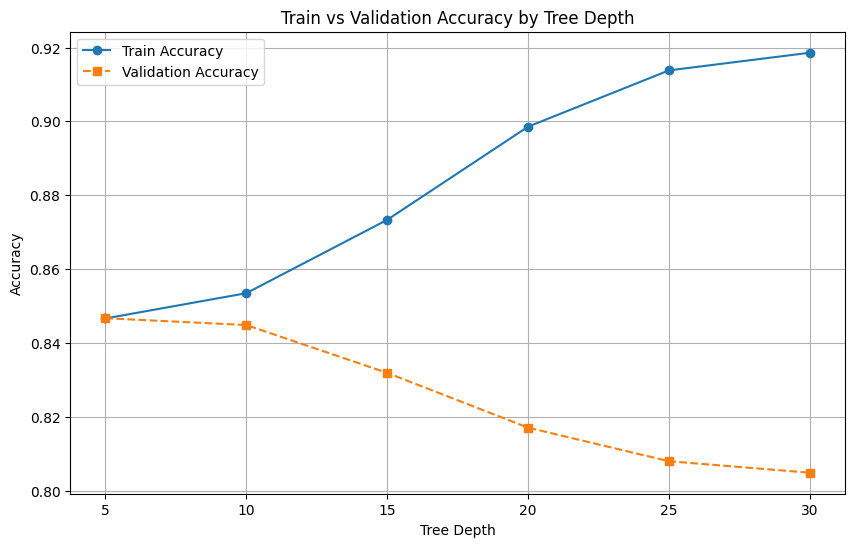

In [50]:
train_scores = [
    np.mean([mean_train_scores[i] for i, d in enumerate(param_max_depth) if d == depth]) 
    for depth in depths
]
val_scores = [
    np.mean([mean_val_scores[i] for i, d in enumerate(param_max_depth) if d == depth]) 
    for depth in depths
]

# Plot training and validation accuracy by tree depth
plt.figure(figsize=(10, 6))
plt.plot(depths, train_scores, marker='o', label='Train Accuracy', linestyle='-')
plt.plot(depths, val_scores, marker='s', label='Validation Accuracy', linestyle='--')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy by Tree Depth')
plt.legend()
plt.grid(True)
plt.show()

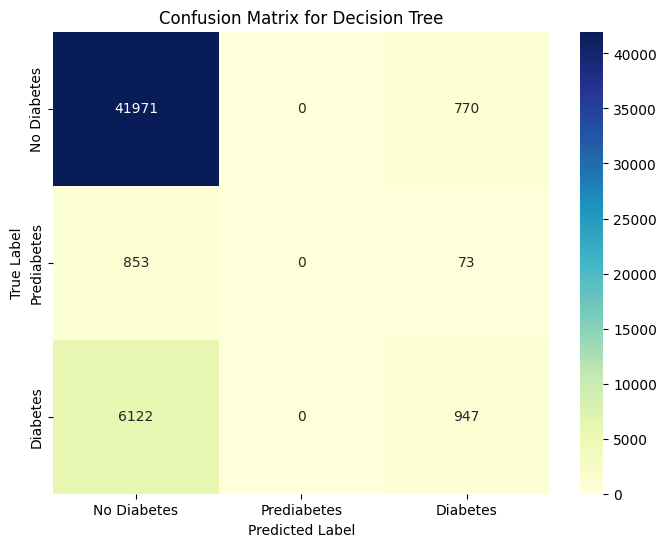

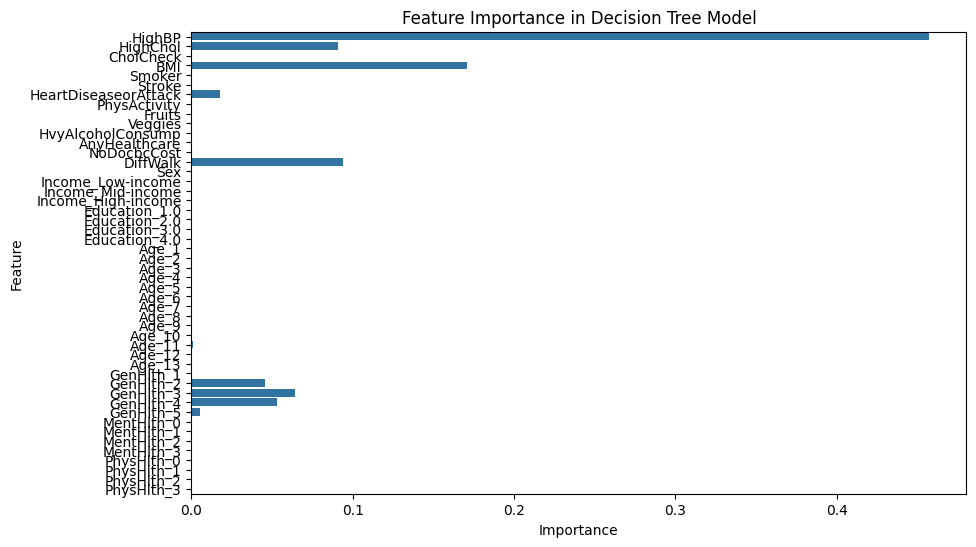

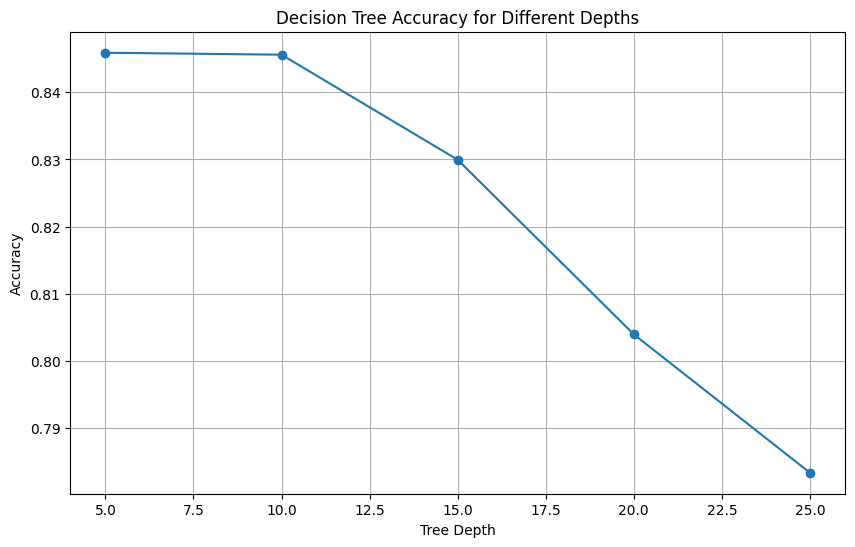

In [51]:
conf_matrix = confusion_matrix(y_test, y_pred_tree)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu", 
            xticklabels=['No Diabetes', 'Prediabetes', 'Diabetes'], 
            yticklabels=['No Diabetes', 'Prediabetes', 'Diabetes'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Decision Tree')
plt.show()

feature_importances = best_tree.feature_importances_
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=X_train.columns)
plt.title('Feature Importance in Decision Tree Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

depths = [5, 10, 15, 20, 25]
accuracies = []
for depth in depths:
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))

plt.figure(figsize=(10, 6))
plt.plot(depths, accuracies, marker='o', linestyle='-') 
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree Accuracy for Different Depths')
plt.grid(True)
plt.show()

In [52]:
tree_model = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=5, 
    min_samples_leaf=1, 
    min_samples_split=2, 
    random_state=42
)

tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree))

Decision Tree Accuracy: 0.8459082308420057
              precision    recall  f1-score   support

         0.0       0.86      0.98      0.92     42741
         1.0       0.00      0.00      0.00       926
         2.0       0.53      0.13      0.21      7069

    accuracy                           0.85     50736
   macro avg       0.46      0.37      0.38     50736
weighted avg       0.80      0.85      0.80     50736



/Users/andrejbasica/anaconda3/envs/new_env_name/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/andrejbasica/anaconda3/envs/new_env_name/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/andrejbasica/anaconda3/envs/new_env_name/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

# Note on Colinearity

As we progressed through the exploratory data analysis, we identified several important relationships and features that will be used in future modeling. However, a potential challenge we need to address is collinearity among these features, as many of them—such as general health, physical health, BMI, and activity level—are strongly interrelated and ultimately reflect a person’s overall lifestyle. This overlap can complicate the model’s ability to distinguish the unique contribution of each feature, potentially explaining why the current model results, while reasonable, may be somewhat underwhelming. In the next milestone, we’ll work on strategies to address collinearity, such as dimensionality reduction or feature selection, to enhance model clarity and predictive accuracy. With these adjustments, we expect that the model’s performance will improve, making this analysis a solid foundation for building a robust diabetes prediction model.



# Summary

We have identified a few predictors with the highest correlation to diabetes as the response variable. Additionally, we have analyzied 4 models, kNN, Logistical Regression, Regular Decisions Tree and Decision Tree with Interactions and have found that the highest accuracy is achieved with a Regula Decision Tree model. Additionally, this model assures our prior findings that the most important predictors are Physical Health, Age, General Health and Income. 

Additionally, we plan to continue looking at new models such as Random Forrest Model in hopes of arriving at a higher accuracy.


# Milestone 4 #
Now, at this point we want to proceed with more advanced model to try to capture more information in the data and use certain features to finetune the Random Forest model. We see that the decision trees do okay, but we are sure that with random forest the varaince will be captured better and we will have created a strong model.

In [53]:
from sklearn.model_selection import RandomizedSearchCV
rf = RandomForestClassifier(random_state=42)

param_distributions = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

random_search_rf = RandomizedSearchCV(
    rf, 
    param_distributions, 
    n_iter=20,  
    cv=5,     
    scoring='accuracy', 
    random_state=42, 
    n_jobs=-1  
)

random_search_rf.fit(X_train, y_train)

best_rf = random_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)


accuracy = accuracy_score(y_test, y_pred_rf)
print("Best Parameters:", random_search_rf.best_params_)
print("Test Accuracy:", accuracy)

/Users/andrejbasica/anaconda3/envs/new_env_name/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/andrejbasica/anaconda3/envs/new_env_name/lib/python3.12/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 15}
Test Accuracy: 0.8488055818353831


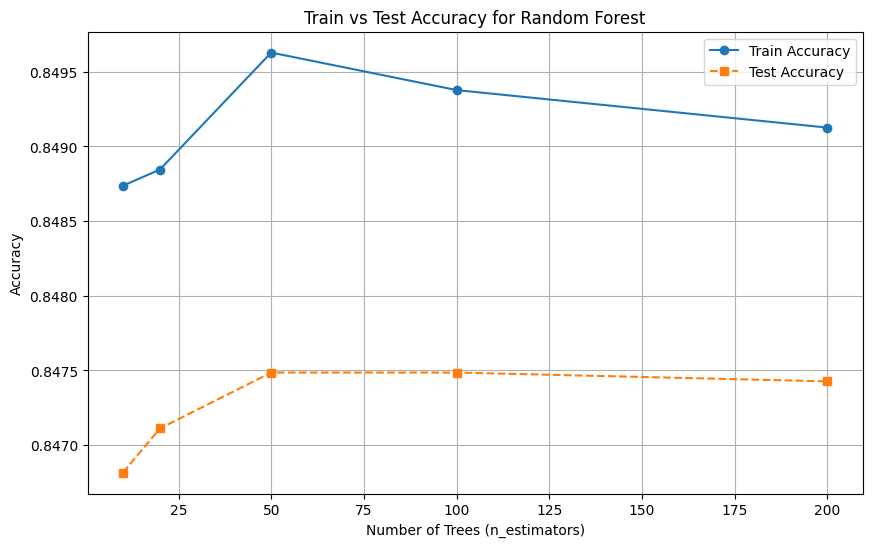

In [54]:
train_scores = []
test_scores = []
n_estimators_values = [10, 20, 50, 100, 200]

for n in n_estimators_values:
    rf_model = RandomForestClassifier(
        n_estimators=n, 
        max_depth=10, 
        min_samples_split=10, 
        min_samples_leaf=2, 
        random_state=42
    )
    rf_model.fit(X_train, y_train)
    train_scores.append(accuracy_score(y_train, rf_model.predict(X_train)))
    test_scores.append(accuracy_score(y_test, rf_model.predict(X_test)))

plt.figure(figsize=(10, 6))
plt.plot(n_estimators_values, train_scores, marker='o', label='Train Accuracy', linestyle='-')
plt.plot(n_estimators_values, test_scores, marker='s', label='Test Accuracy', linestyle='--')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy for Random Forest')
plt.legend()
plt.grid(True)
plt.show()

# ADA Boosting #

Fitting 3 folds for each of 27 candidates, totalling 81 fits


/Users/andrejbasica/anaconda3/envs/new_env_name/lib/python3.12/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/Users/andrejbasica/anaconda3/envs/new_env_name/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/andrejbasica/anaconda3/envs/new_env_name/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/andrejbasica/anaconda3/envs/new_env_name/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/andrejbasica/anaconda3/envs/new_env_name/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names,

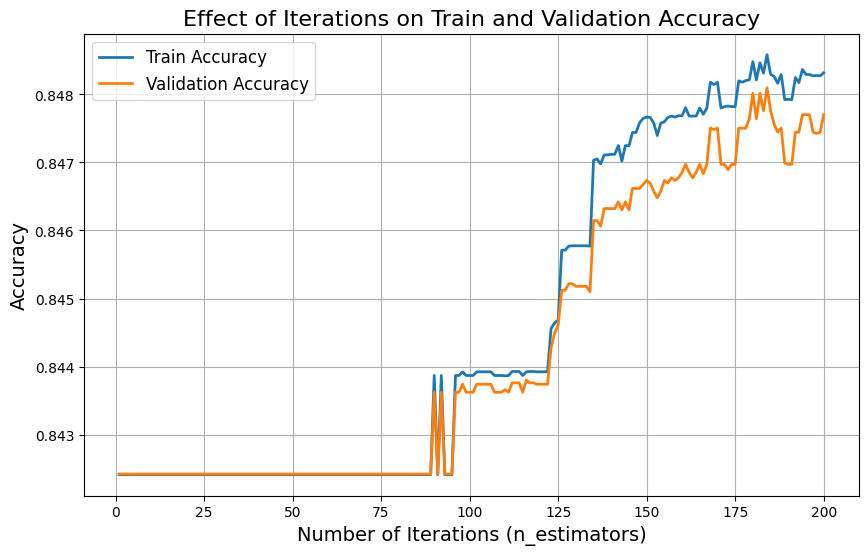

Best Parameters: {'estimator__max_depth': 3, 'learning_rate': 0.01, 'n_estimators': 200}
Validation Accuracy: 0.8480960264900662


In [55]:
from sklearn.ensemble import AdaBoostClassifier

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'estimator__max_depth': [1, 2, 3],
}

base_estimator = DecisionTreeClassifier(random_state=42, min_samples_leaf=1, min_samples_split=2)

ada_boost = AdaBoostClassifier(
    estimator=base_estimator,
    algorithm="SAMME",
    random_state=42
)

grid_search = GridSearchCV(
    ada_boost,
    param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

best_ada_boost = grid_search.best_estimator_

best_ada_boost.fit(X_train, y_train)

train_accuracies = list(best_ada_boost.staged_score(X_train, y_train))
val_accuracies = list(best_ada_boost.staged_score(X_test, y_test))

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Train Accuracy", linewidth=2)
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation Accuracy", linewidth=2)
plt.xlabel("Number of Iterations (n_estimators)", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Effect of Iterations on Train and Validation Accuracy", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

print("Best Parameters:", grid_search.best_params_)
print("Validation Accuracy:", max(val_accuracies))


Test Accuracy: 0.8477018290760012

Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.99      0.92     42741
         1.0       0.00      0.00      0.00       926
         2.0       0.56      0.13      0.21      7069

    accuracy                           0.85     50736
   macro avg       0.47      0.37      0.37     50736
weighted avg       0.80      0.85      0.80     50736



/Users/andrejbasica/anaconda3/envs/new_env_name/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/andrejbasica/anaconda3/envs/new_env_name/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/andrejbasica/anaconda3/envs/new_env_name/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

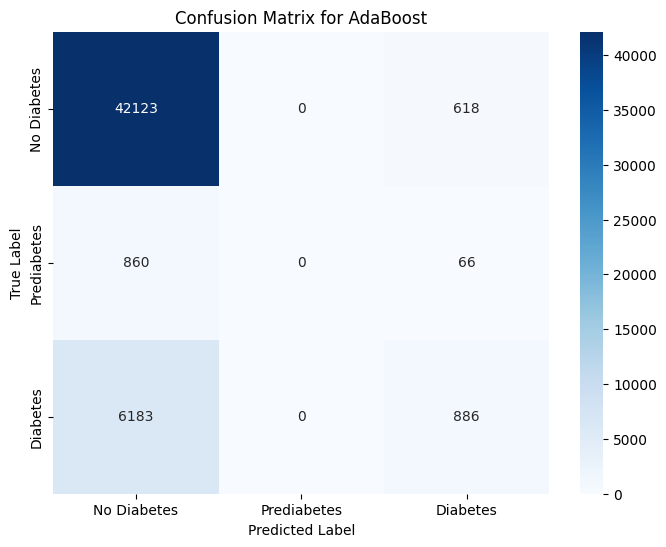

0.8480960264900662

In [56]:
base_estimator = DecisionTreeClassifier(random_state=42, max_depth=3, min_samples_leaf=1, min_samples_split=2)

# Define AdaBoostClassifier
ada_model = AdaBoostClassifier(
    estimator=base_estimator,
    random_state=42,
    algorithm = 'SAMME',
    learning_rate = 0.01,
    n_estimators = 200
)

ada_model.fit(X_train, y_train)
y_pred_ada = ada_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_ada)
print("Test Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred_ada))

conf_matrix_ada = confusion_matrix(y_test, y_pred_ada)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_ada, annot=True, fmt="d", cmap="Blues",
            xticklabels=['No Diabetes', 'Prediabetes', 'Diabetes'], 
            yticklabels=['No Diabetes', 'Prediabetes', 'Diabetes'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for AdaBoost')
plt.show()

# Validation accuracy
val_accuracy = max(val_accuracies)
val_accuracy

The AdaBoost model has a high accuracy of 84.8%, but it struggles with predicting class diabetes, showing an f1-score of 0.21. The macro average f1-score is low at 0.37, showing the model performs poorly on the smaller classes. This happens because the model focuses too much on the majority class no-diabetes, which has an f1-score of 0.92. To fix this, the data imbalance needs to be addressed, such as by balancing the classes or tweaking the model.

Number of components explaining 95% variance: 33


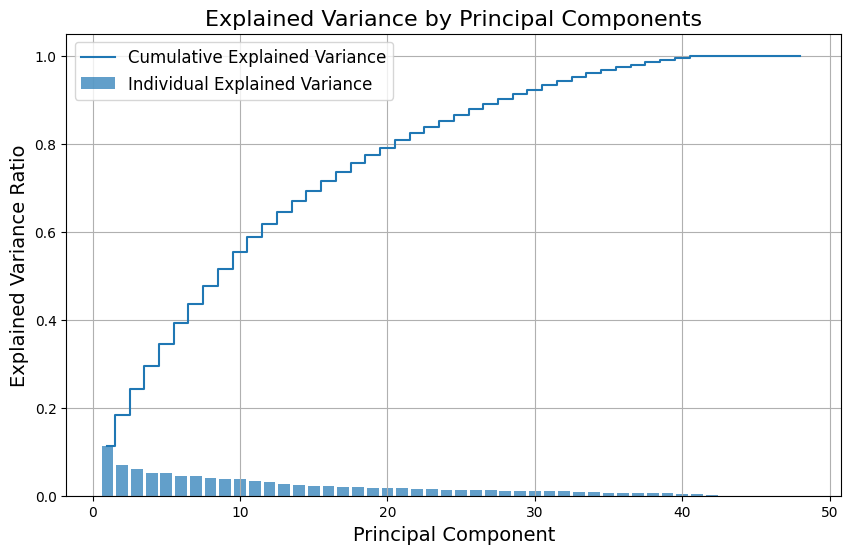

In [58]:
pca = PCA().fit(X_train)


cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components explaining 95% variance: {n_components}")


plt.figure(figsize=(10, 6))
plt.bar(
    np.arange(1, len(pca.explained_variance_ratio_) + 1),
    pca.explained_variance_ratio_,
    alpha=0.7,
    align='center',
    label='Individual Explained Variance'
)
plt.step(
    np.arange(1, len(cumulative_variance) + 1),
    cumulative_variance,
    where='mid',
    label='Cumulative Explained Variance'
)
plt.xlabel('Principal Component', fontsize=14)
plt.ylabel('Explained Variance Ratio', fontsize=14)
plt.title('Explained Variance by Principal Components', fontsize=16)
plt.legend(loc='best', fontsize=12)
plt.grid(True)
plt.show()

The graph shows the explained variance by each principal component and the cumulative variance as features are added. With 42 total features, we see that approximately 20 principal components are needed to capture around 80% of the variance in the data. This suggests that dimensionality can be significantly reduced while retaining most of the information.

In [59]:
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

columns = [f'PC{i+1}' for i in range(n_components)]
X_train_pca_df = pd.DataFrame(X_train_pca, columns=columns)
X_test_pca_df = pd.DataFrame(X_test_pca, columns=columns)
print(f"Transformed training dataset shape: {X_train_pca_df.shape}")
print(f"Transformed test dataset shape: {X_test_pca_df.shape}")

Transformed training dataset shape: (202944, 33)
Transformed test dataset shape: (50736, 33)


# Next Steps #

After initially planning to use SMOTE for all our models, we discussed with our mentor and decided to take a more tailored approach. Even with these adjustments, we found that the models still struggled with some of the underrepresented classes. To address this, we experimented with balancing the dataset, which helped improve accuracy for the minority classes and increased the macro average—meaning the models performed better across all classes individually. However, the overall accuracy didn’t see much improvement because the majority class still dominated the results. Moving forward, we plan to prioritize the diabetes class by assigning it more weight in the models. We believe that adjusting the weights could enhance the classification of diabetes without negatively affecting the balance of the overall model, and we intend to explore boosting techniques as part of this effort.